# **Modeling and Evaluation (Regression) Notebook**

## Objectives
- Fit and evaluate a regression model to predict the Sales Price for a house in Ames, Iowa

## Inputs
- outputs/data_collected/house_oricing_data.csv
- Instructions on which variables to use for data cleaning and feature engineering. They are found in notebook 01 - 03.

## Outputs
- Train set
- Test set
- Data cleaning and Feature Engineering pipeline
- Modeling pipeline


---

## Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspaces/ci-c5-housing-market-prices/jupyter_notebooks'

In [ ]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


In [3]:
current_dir = os.getcwd()
current_dir

'/workspaces/ci-c5-housing-market-prices'

---

## Step 1: Load data

In [47]:
import numpy as np
import pandas as pd
df = (pd.read_csv("outputs/data_collected/house_pricing_data.csv")  
  )

print(df.shape)
df.head(3)

(1460, 24)


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,0.0,548,RFn,...,65.0,196.0,61,5,7,856,0.0,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,NaN,460,RFn,...,80.0,0.0,0,8,6,1262,NaN,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,0.0,608,RFn,...,68.0,162.0,42,5,7,920,NaN,2001,2002,223500


In [19]:
# Count missing values per column
missing_count_per_column = df.isnull().sum()

# Filter and sort columns with missing values
missing_columns = missing_count_per_column[missing_count_per_column > 0].sort_values(ascending=False)

print("\nColumns with Missing Values and Their Counts:")
print(missing_columns)


Columns with Missing Values and Their Counts:
EnclosedPorch    1324
WoodDeckSF       1305
LotFrontage       259
GarageFinish      235
BsmtFinType1      145
BedroomAbvGr       99
2ndFlrSF           86
GarageYrBlt        81
BsmtExposure       38
MasVnrArea          8
dtype: int64


---

## Step 2: ML Pipeline with all relevant data

ML pipeline for Data Cleaning and Feature Engineering

In [48]:
from sklearn.pipeline import Pipeline

# preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

# Feature Engineering
from feature_engine.selection import SmartCorrelatedSelection # Import SmartCorrelationSelection
from feature_engine.encoding import OrdinalEncoder # Import OrdinalEncoder
from feature_engine.transformation import LogTransformer  # Import LogTransformer
from feature_engine.imputation import MeanMedianImputer # For Imputation

def drop_unwanted_columns(X):
    return X.drop(columns=[
        'LotFrontage', 'GarageFinish', '2ndFlrSF', 'GarageYrBlt',
        'EnclosedPorch', 'WoodDeckSF', 'BsmtFinType1', 'LotArea',
        'BsmtUnfSF', 'BedroomAbvGr', 'BsmtExposure', 'OverallCond'
    ])


def PipelineDataCleaningAndFeatureEngineering():
    pipeline_base = Pipeline([
        # Drop unwanted columns
        ("DropUnwantedFeatures", FunctionTransformer(drop_unwanted_columns, validate=False)),

        # Impute MasVnrArea using mean
        ("ImputeMasVnrArea", MeanMedianImputer(imputation_method='mean', variables=['MasVnrArea'])),

        # Encoding categorical variables using OrdinalEncoder
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['KitchenQual'])),

         # Feature selection based on correlation using SmartCorrelatedSelection
        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=['TotalBsmtSF', '1stFlrSF', 'KitchenQual', 'YearRemodAdd', 'GarageArea'],
         method="spearman", threshold=0.6, selection_method="variance")),

        # Apply log10 transformation to selected numeric features
        # SalePrice is removed due to X_train data
        ("LogTransformation", LogTransformer(variables=['GrLivArea'], base='10'))

    ])

    return pipeline_base


# Run the pipeline
PipelineDataCleaningAndFeatureEngineering()

Pipeline(steps=[('DropUnwantedFeatures',
                 FunctionTransformer(func=<function drop_unwanted_columns at 0x735ff8656fc0>)),
                ('ImputeMasVnrArea',
                 MeanMedianImputer(imputation_method='mean',
                                   variables=['MasVnrArea'])),
                ('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['KitchenQual'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6,
                                          variables=['TotalBsmtSF', '1stFlrSF',
                                                     'KitchenQual',
                                                     'YearRemodAdd',
                                                     'GarageArea'])),
                ('LogTransformation',
                 LogTransformer(base='10', variables=['GrLivArea']))])

In [49]:
# 1. Get the pipeline
pipeline = PipelineDataCleaningAndFeatureEngineering()

# 2. Fit and transform  DataFrame
df_transformed = pipeline.fit_transform(df)

# 3. View the result
print(df_transformed.head())

   BsmtFinSF1  GarageArea  GrLivArea  KitchenQual  MasVnrArea  OpenPorchSF  \
0         706         548   3.232996            0       196.0           61   
1         978         460   3.101059            1         0.0            0   
2         486         608   3.251881            0       162.0           42   
3         216         642   3.234770            0         0.0           35   
4         655         836   3.342028            0       350.0           84   

   OverallQual  TotalBsmtSF  YearBuilt  YearRemodAdd  SalePrice  
0            7          856       2003          2003     208500  
1            6         1262       1976          1976     181500  
2            7          920       2001          2002     223500  
3            7          756       1915          1970     140000  
4            8         1145       2000          2000     250000  


/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):


ML Pipeline for Modelling, import libaries (in progress)

In [64]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler


# Feat Scaling
from sklearn.preprocessing import StandardScaler

# Feat Selection
from sklearn.feature_selection import SelectFromModel

# ML algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from xgboost import XGBRegressor


def PipelineRegressor(model):
    pipeline_base = Pipeline([
        ("scaler", StandardScaler()),
        ("feat_selection", SelectFromModel(model)),
        ("model", model),
    ])

    return pipeline_base

### Hyperparameter Optimisation

Use GridSearch algorithm to find the best combination of hyperparameters for the model.

In [ ]:
from sklearn.model_selection import GridSearchCV


class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")

            model = PipelineRegressor(self.models[key])
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, )
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)
        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]
        return df[columns]

### Train-test split after transforming the target

X_train and y_train will be used to train the model.
X_test and y_test will be used to evaluate the model.

X set is dropping 'SalePrice' since it is the target variable.
Y contains only the target variable.

In [60]:
from sklearn.model_selection import train_test_split

# Transform target variable
df['SalePrice'] = np.log10(df['SalePrice'])

# Split into features and target
X = df.drop('SalePrice', axis=1) # All columns except 'SalePrice' are features
y = df['SalePrice'] # 'SalePrice' is the target variable

# Split into train and test sets (80% train, 20% test is common)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### Apply the pipeline to training and testing features

In [61]:
pipeline = PipelineDataCleaningAndFeatureEngineering()

X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1168, 10) (1168,) (292, 10) (292,)


/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):


* 1168 training samples  and 292 test samples are created

### Check Target Imbalance

Check Target distribution of Train Set --> target shouldn't be imbalance because of the numeric tranformation of sales price (log10)

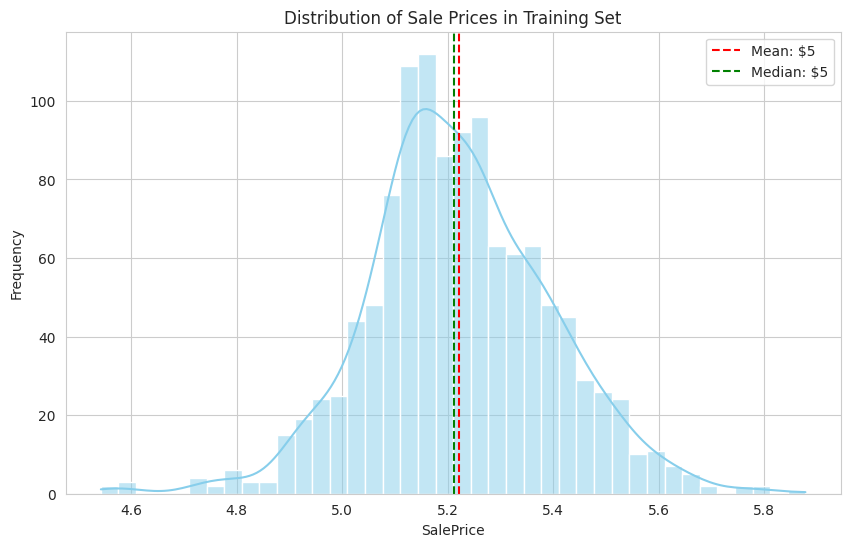

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot target distribution
plt.figure(figsize=(10, 6))
sns.histplot(y_train, bins=40, kde=True, color='skyblue')
plt.axvline(y_train.mean(), color='red', linestyle='--', label=f'Mean: ${y_train.mean():,.0f}')
plt.axvline(y_train.median(), color='green', linestyle='--', label=f'Median: ${y_train.median():,.0f}')
plt.title("Distribution of Sale Prices in Training Set")
plt.xlabel("SalePrice")
plt.ylabel("Frequency")
plt.legend()
plt.show()

---

### Hyperparameter Optimization Search (Grid Search)

1. Test multiple algorithms and choose the best one
2. Run multiple hyperparameter on the selected algorithm to identify the best hyperparameter.

#### Test multiple algorithms with Grid Search CV

In [70]:
# Algorithms that will be used/ tested
models_quick_search = {
    "XGBRegressor": XGBRegressor(random_state=0),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
}

# Define hyperparameter for each algorithm
# empty {} means default hyperparameter will be used
params_quick_search = {
    "XGBRegressor": {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "GradientBoostingRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
}

Apply algorithms to Train data

In [71]:
from sklearn.metrics import make_scorer, recall_score

# Start HyperparameterOptimizationSeach
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)

# Fir model with training data
search.fit(X_train, y_train,
           scoring = 'neg_mean_absolute_error',
           n_jobs=-1, cv=5)

# To check the results:
search.score_summary()


Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/cistudent/.local/lib/python3.12/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/cistudent/.local/lib/python3.12/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/cistudent/.local/lib/python3.12/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/cistudent/.local/lib/python3.12/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/cistudent/.local/lib/python3.12/site-packages/xgboost/data.py:440: FutureWarning: is_spars


Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


(                   estimator min_score mean_score max_score std_score
 4        ExtraTreesRegressor -0.005553  -0.005219 -0.004774   0.00031
 3  GradientBoostingRegressor -0.005844  -0.005574 -0.005294  0.000199
 0               XGBRegressor -0.006509  -0.005854 -0.005571  0.000347
 2      RandomForestRegressor -0.006388  -0.006052 -0.005531   0.00029
 5          AdaBoostRegressor -0.006988   -0.00649 -0.005478   0.00054
 1      DecisionTreeRegressor -0.007559  -0.006992 -0.006417  0.000363,
 {'XGBRegressor': GridSearchCV(cv=5,
               estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                         ('feat_selection',
                                          SelectFromModel(estimator=XGBRegressor(base_score=None,
                                                                                 booster=None,
                                                                                 callbacks=None,
                                            

Check results

In [72]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary 

,estimator,min_score,mean_score,max_score,std_score
4,ExtraTreesRegressor,-0.005553,-0.005219,-0.004774,0.00031
3,GradientBoostingRegressor,-0.005844,-0.005574,-0.005294,0.000199
0,XGBRegressor,-0.006509,-0.005854,-0.005571,0.000347
2,RandomForestRegressor,-0.006388,-0.006052,-0.005531,0.00029
5,AdaBoostRegressor,-0.006988,-0.00649,-0.005478,0.00054
1,DecisionTreeRegressor,-0.007559,-0.006992,-0.006417,0.000363


A negative mean absolute error (neg_mean_absolute_error) is used as the evaluation metric.

* Lower (negative) MAE values indicate better performance.
* Since the metric is negative, values closer to zero are better.

First results:
* ExtraTreesRegressor: Mean score around -0.0052 (best performance).
* GradientBoostingRegressor: Mean score around -0.0056.
* XGBRegressor: Mean score around -0.0058.
* RandomForestRegressor: Mean score around -0.0060.
* AdaBoostRegressor: Mean score around -0.0065.
* DecisionTreeRegressor: Mean score around -0.0070 (lowest performance).

---

### Define model and parameters, for Extensive Search

Based on the results ExtraTreesRegressor model is the best working on. THis one is selected. In the next steps the best hyperparameter set up is defined. 

In [75]:
# Initialize the ExtraTreesRegressor model
model = ExtraTreesRegressor(n_estimators=100, random_state=42)

# Fit the model on the training data
model.fit(X_train_scaled, y_train)

ExtraTreesRegressor(random_state=42)

In [ ]:
# ExtraTreesRegressor
models_quick_search = {
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
}

# Define hyperparameter for each algorithm
params_quick_search = {
    "ExtraTreesRegressor": {
        "n_estimators": [100, 200],
        "max_depth": [None, 20],
        "min_samples_split": [2, 5],
    }
}

Apply algorithm and various hyperparameter to test data

In [78]:
from sklearn.metrics import make_scorer, recall_score

# Start HyperparameterOptimizationSeach
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)

# Fir model with training data
search.fit(X_train, y_train,
           scoring = 'neg_mean_absolute_error',
           n_jobs=-1, cv=5)

# To check the results:
search.score_summary()


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 8 candidates, totalling 40 fits


(             estimator min_score mean_score max_score std_score  \
 7  ExtraTreesRegressor -0.005426  -0.004982 -0.004475  0.000323   
 6  ExtraTreesRegressor -0.005444  -0.004986 -0.004459   0.00033   
 3  ExtraTreesRegressor -0.005432  -0.004992 -0.004509  0.000315   
 2  ExtraTreesRegressor -0.005445  -0.004996 -0.004483  0.000322   
 1  ExtraTreesRegressor -0.005575    -0.0052 -0.004767  0.000321   
 4  ExtraTreesRegressor -0.005567    -0.0052 -0.004776  0.000318   
 5  ExtraTreesRegressor -0.005589  -0.005201 -0.004766  0.000327   
 0  ExtraTreesRegressor -0.005553  -0.005219 -0.004774   0.00031   
 
   model__max_depth model__min_samples_split model__n_estimators  
 7               20                        5                 200  
 6               20                        5                 100  
 3             None                        5                 200  
 2             None                        5                 100  
 1             None                        2       

Check results

In [79]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary 

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__min_samples_split,model__n_estimators
7,ExtraTreesRegressor,-0.005426,-0.004982,-0.004475,0.000323,20,5,200
6,ExtraTreesRegressor,-0.005444,-0.004986,-0.004459,0.00033,20,5,100
3,ExtraTreesRegressor,-0.005432,-0.004992,-0.004509,0.000315,None,5,200
2,ExtraTreesRegressor,-0.005445,-0.004996,-0.004483,0.000322,None,5,100
1,ExtraTreesRegressor,-0.005575,-0.0052,-0.004767,0.000321,None,2,200
4,ExtraTreesRegressor,-0.005567,-0.0052,-0.004776,0.000318,20,2,100
5,ExtraTreesRegressor,-0.005589,-0.005201,-0.004766,0.000327,20,2,200
0,ExtraTreesRegressor,-0.005553,-0.005219,-0.004774,0.00031,None,2,100


Best score: **ExtraTreesRegressor7 (0.004982)**

---

## Define pipeline with the best set up

Model type: 
ExtraTreesRegressor

Hyperparameter: 
* model_max_depth: 20
* model_min_samples_split: 5
* model_n_estimators: 200

In [89]:
from sklearn.ensemble import ExtraTreesRegressor # already imported on top

# Initialize the ExtraTreesRegressor model
pipeline_regressor = ExtraTreesRegressor(
    max_depth=20,
    min_samples_split=5,
    n_estimators=100
)

# Fit the model on the training data
pipeline_regressor.fit(X_train_scaled, y_train)

ExtraTreesRegressor(max_depth=20, min_samples_split=5)

### Make Predictions and Evaluate the Model (in progress)

In [90]:
from sklearn.metrics import mean_absolute_error # already imported on top

# Make predictions on the test set
y_pred = pipeline_regressor.predict(X_test_scaled)

# Evaluate the model using different metrics
mae = mean_absolute_error(y_test, y_pred)  # Mean Absolute Error
mse = mean_squared_error(y_test, y_pred)    # Mean Squared Error
rmse = mean_squared_error(y_test, y_pred, squared=False)  # Root Mean Squared Error

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")


Mean Absolute Error (MAE): 67458.95590572215
Mean Squared Error (MSE): 8679871212.218628
Root Mean Squared Error (RMSE): 93165.82641837418


---

## Step 3: Refine pipeline with best features

Only apply the six relevant features (= variables) for a new pipeline.

---

##  Step 4: Push files to Repo

The following files will be generated:
- Train Set
- Test Set
- Data cleaning and Feature Engineering pipeline
- Regressor pipeline

In [91]:
pipeline_dc_fe = PipelineDataCleaningAndFeatureEngineering()

In [92]:
import joblib
import os

version = 'v1'
file_path = f'outputs/ml_pipelines/predict_SalePrice/{version}'

try:
    os.makedirs(name=file_path)
except Exception as e:
    print(e)

# Save trained model
joblib.dump(value=pipeline_dc_fe ,
            filename=f"{file_path}/pipeline_data_cleaning_feat_eng.pkl")
joblib.dump(value=pipeline_regressor ,
            filename=f"{file_path}/pipeline_regressor.pkl")

[Errno 17] File exists: 'outputs/ml_pipelines/predict_SalePrice/v1'


['outputs/ml_pipelines/predict_SalePrice/v1/pipeline_regressor.pkl']

## Train Set

In [1]:
print(X_train.shape)
X_train.head()

NameError: name 'X_train' is not defined

In [43]:
X_train.to_csv(f"{file_path}/X_train.csv", index=False)

In [44]:
y_train

254     5.161368
1066    5.250420
638     4.929419
799     5.243038
380     5.103804
          ...   
1095    5.246577
1130    5.130334
1294    5.060698
860     5.278639
1126    5.240549
Name: SalePrice, Length: 1168, dtype: float64

In [45]:
y_train.to_csv(f"{file_path}/y_train.csv", index=False)

## Test Set

In [46]:
print(X_test.shape)
X_test.head()

(292, 10)


,BsmtFinSF1,GarageArea,GrLivArea,KitchenQual,MasVnrArea,OpenPorchSF,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd
892,663,264,3.028571,1,0.0,0,6,1059,1963,2003
1105,1032,712,3.418633,0,362.0,32,8,1463,1994,1995
413,0,360,3.011993,1,0.0,0,5,1008,1927,1950
522,399,420,3.221153,1,0.0,24,6,1004,1947,1950
1036,1022,912,3.209515,2,70.0,0,9,1620,2007,2008


In [47]:
X_test.to_csv(f"{file_path}/X_test.csv", index=False)

In [48]:
y_test

892     5.188928
1105    5.511883
413     5.060698
522     5.201397
1036    5.498999
          ...   
479     4.951682
1361    5.414973
802     5.276462
651     5.033424
722     5.095169
Name: SalePrice, Length: 292, dtype: float64

In [49]:
y_test.to_csv(f"{file_path}/y_test.csv", index=False)

---

## Step 5: Combine Data Engineering and Regressor pipeline (in progress)

In [87]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from feature_engine.selection import SmartCorrelatedSelection
from feature_engine.encoding import OrdinalEncoder
from feature_engine.transformation import LogTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
import joblib
import os
import pandas as pd
from sklearn.model_selection import train_test_split

# Load data
df = pd.read_csv("outputs/data_collected/house_pricing_data.csv")

# Define features and target
X = df.drop(columns=['SalePrice'])  # Assuming you already have SalePrice
y = df['SalePrice']

# Data cleaning: Drop specified columns and fill missing values for relevant columns
X = X.drop(columns=['BsmtFinType1', 'LotArea', 'BsmtFinType1', 'BsmtUnfSF', 'BedroomAbvGr', 'BsmtExposure', 'OverallCond', 'GarageYrBlt', 'LotFrontage', 'EnclosedPorch', 'WoodDeckSF', 'TotalBsmtSF', '1stFlrSF', 'GarageArea', '2ndFlrSF', 'KitchenQual', 'GarageFinish'])

# Data cleaning: Fill missing values in 'MasVnrArea' column with the mean
X['MasVnrArea'] = X['MasVnrArea'].fillna(X['MasVnrArea'].mean())

# Data cleaning: Ensure the columns to which you will apply the log transformation are float64
X['GrLivArea'] = X['GrLivArea'].astype('float64')

# Define preprocessing steps
preprocessing = Pipeline([
        # Apply log10 transformation to selected numeric features
        ("LogTransformation", LogTransformer(variables=['GrLivArea'], base='10'))
    ])

# Combine preprocessing with model
full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("pipline_regressor", pipline_regressor)
    # ("model", RandomForestRegressor(n_estimators=100, random_state=42))
])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
full_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('LogTransformation',
                                  LogTransformer(base='10',
                                                 variables=['GrLivArea']))])),
                ('pipline_regressor',
                 ExtraTreesRegressor(max_depth=20, min_samples_split=5))])

---

## Model evaluation

In [88]:
y_pred = full_pipeline.predict(X_test)

# Evaluate the model using different metrics
mae = mean_absolute_error(y_test, y_pred)  # Mean Absolute Error
mse = mean_squared_error(y_test, y_pred)    # Mean Squared Error
rmse = mean_squared_error(y_test, y_pred, squared=False)  # Root Mean Squared Error

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Absolute Error (MAE): 20681.795260437055
Mean Squared Error (MSE): 969655741.1103821
Root Mean Squared Error (RMSE): 31139.295770944824


Save pipeline

In [93]:
# Create folder if needed
model_path = "outputs/ml_pipelines/predict_SalePrice/v1"
os.makedirs(model_path, exist_ok=True)

# Save pipeline
joblib.dump(full_pipeline, f"{model_path}/full_pipeline.pkl")

['outputs/ml_pipelines/predict_SalePrice/v1/full_pipeline.pkl']

---

## Visualisatons (in progress)

### Residuals Plot (for Regression Models)

Purpose: To check if residuals (errors) are randomly distributed. This helps in validating assumptions of homoscedasticity in regression models.

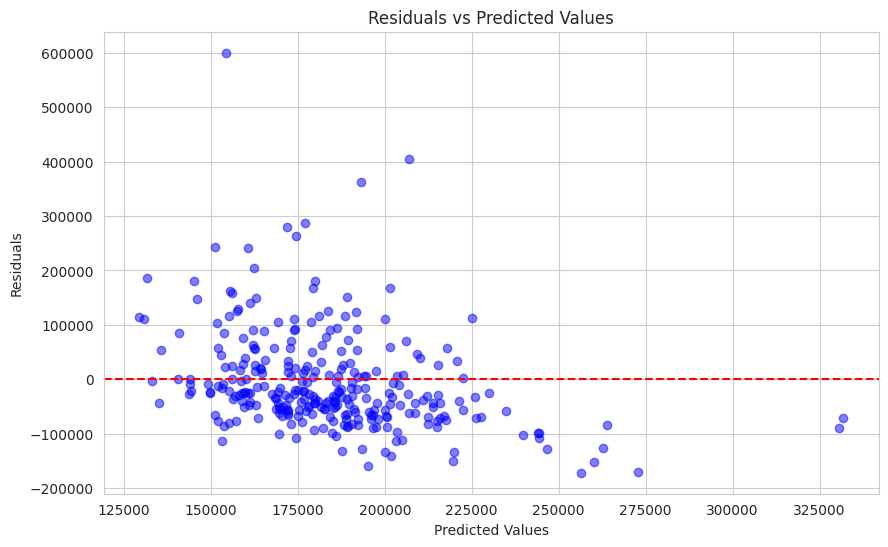

In [94]:
import matplotlib.pyplot as plt

# Assuming there is a regression model and y_pred provided
residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, color='blue', alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.show()